https://pytorch.org/docs/stable/optim.html

In [106]:
!pip3 install Pillow==4.0.0
!pip3 install torch==0.4.0
!pip3 install torchvision==0.2.1
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/d1/24/f53ff6b61b3d728b90934bddb4f03f8ab584a7f49299bf3bde56e2952612/Pillow-5.2.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.optimは、さまざまな最適化アルゴリズムを実装するパッケージです。最も一般的に使用されているメソッドはすでにサポートされており、インターフェイスは一般的なので、より洗練されたメソッドも将来簡単に統合できます。




# Mnistの例

In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# epochs = 1
epochs = 20
batch_size = 100
log_interval = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#モデルの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#実行クラス
class Runner():
    def __init__(self, model):
        self.model = model
        self.scheduler = None

    def train(self, model, device, train_loader, optimizer, epoch, use_scheduler=False):
        model.train()
        train_loss_list = []
        if use_scheduler == True:
            self.scheduler.step()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() #勾配クリア
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()  #誤差逆伝播の計算
            optimizer.step() #重みの更新
            
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Lr：{} '.format(
                    epoch, batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item(), #lossはloss.item()
                    optimizer.param_groups[0]["lr"]
                ))
                train_loss_list.append(loss.item())
        return train_loss_list

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        test_loss_list = []
        correct_list = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, 
            correct, 
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        ))
        correct_list.append(100. * correct / len(test_loader.dataset))
        test_loss_list.append(test_loss)
        return test_loss_list, correct_list

データの読み込み

In [0]:

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=200)

# SGD

確率的勾配降下法。


```
class torch.optim.SGD(params, lr=<object object>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```

params：モデルのパラメータ    
lr：学習率    
momentum：モメンタム（デフォルト０）    
weight_decay：減衰（L2ペナルティ）（デフォルト：0）    
dampening：モメンタムの減衰（デフォルト０）    
nesterov：Nesterovモメンタム（デフォルト:False）    




In [86]:
model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293110	 Lr：0.01 
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.294840	 Lr：0.01 
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.300391	 Lr：0.01 
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.307047	 Lr：0.01 
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.291754	 Lr：0.01 
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.297678	 Lr：0.01 
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.305028	 Lr：0.01 
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.295594	 Lr：0.01 
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.277427	 Lr：0.01 
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.287415	 Lr：0.01 
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.278700	 Lr：0.01 
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.283114	 Lr：0.01 
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.265447	 Lr：0.01 
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.269015	 Lr：0.01 
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.273201	 Lr：0.01 
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.277119	 Lr：0.01 
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.277806	 Lr：0.01 

KeyboardInterrupt: ignored

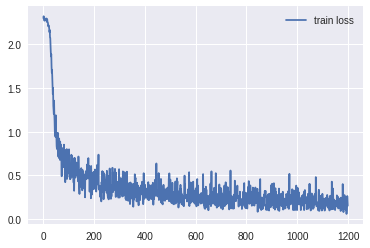

In [9]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()

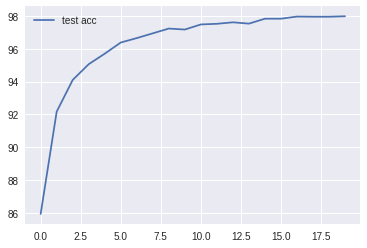

In [11]:
# plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()

## Adadelta

Adadeltaアルゴリズム。


```
class torch.optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
```

In [76]:
model = Net()
model.cuda()

#Adadelta
optimizer = optim.Adadelta(model.parameters(), rho=0.9)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

1.0
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300781	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.252757	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.967374	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [3000/60000 (5%)]	Loss: 1.441400	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.064662	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.942860	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.891668	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.557082	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.610009	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.697508	 Lr：1 
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.64

KeyboardInterrupt: ignored

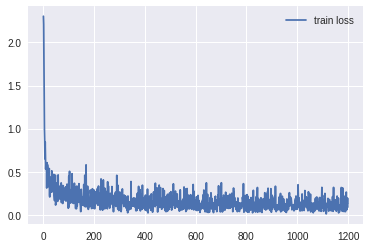

In [13]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()

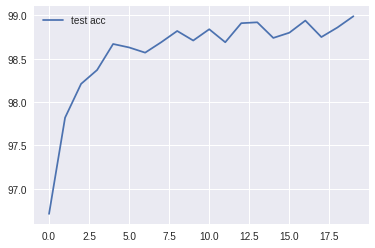

In [14]:
plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()

## Adagrad

```
class torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
```

params：モデルのパラメータ    
lr：学習率（デフォルト：1e-2）    
lr_decay：学習率減衰（デフォルト０）    
weight_decay：重み減衰（L2ペナルティ）（デフォルト０）    


In [77]:
model = Net()
model.cuda()

#Adagrad
optimizer = optim.Adagrad(model.parameters())

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

0.01
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301919	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [1000/60000 (2%)]	Loss: 1.939073	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.200675	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [3000/60000 (5%)]	Loss: 1.071526	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.009009	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.763581	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.747704	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.885682	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.646596	 Lr：1 
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.750571	 

KeyboardInterrupt: ignored

## Adam


```
class torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
```

params：モデルのパラメータ    
lr：学習率（1e-3）    
betas：勾配とその二乗の実行平均を計算するために使用される係数（デフォルト：（0.9、0.999））    
eps：分母に項を加えて数値的安定性を向上させる（デフォルト：1e-8）    
weight_decay：重み減衰（L2ペナルティ）（デフォルト０）    
amsgrad：AMSGrad variant    



In [0]:
model = Net()
model.cuda()

#Adam
optimizer = optim.Adam(model.parameters())

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

## SparseAdam

Adamのlazyバージョン。スパーステンソルむけ。


```
class torch.optim.SparseAdam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
```


In [0]:
# model = Net()
# model.cuda()

# #SparseAdam
# optimizer = optim.SparseAdam(model.parameters())

# train_loss_list = []
# test_loss_list = []
# correct_list = []

# runner = Runner(model)

# def main(optimizer, model):
#     for epoch in range(1, epochs + 1):
#         ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
#         train_loss_list.extend(ref_loss)
#         ref_loss, ref_correct = runner.test(model, device, test_loader)
#         test_loss_list.extend(ref_loss)
#         correct_list.extend(ref_correct)
#     return train_loss_list, test_loss_list, correct_list
        
# train_loss_list, test_loss_list, correct_list = main(optimizer, model)

In [0]:
# plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
# plt.legend()

In [0]:
# plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
# plt.legend()

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp

n_samples = 100
n_features = 20
X_ = np.random.random([n_samples, n_features]).astype(np.float32)
A_ = sp.random(n_samples, n_samples, dtype=np.float32)

def to_torch_sparse_tensor(M):
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col))).long()
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    T = torch.sparse.FloatTensor(indices, values, shape)
    return T

X = torch.from_numpy(X_)
A = to_torch_sparse_tensor(A_)

class GraphConv(nn.Module):
    def __init__(self, size_in, size_out):
        super(GraphConv, self).__init__()
        self.W = nn.parameter.Parameter(torch.Tensor(size_in, size_out))
        self.b = nn.parameter.Parameter(torch.Tensor(size_out))
        # Initialize weights
        variance = 2 / (size_in + size_out)
        self.W.data.normal_(0.0, variance)
        self.b.data.normal_(0.0, variance)
    
    def forward(self, X, A):
        return torch.mm(torch.mm(A, X), self.W) + self.b

model = GraphConv(X.size()[1], 128)
optimizer = optim.SparseAdam(model.parameters())
optimizer.zero_grad() #勾配クリア

output = model(X, A)
# loss = F.nll_loss(output, output)

#             output = model(data)
            
# loss.backward()  #誤差逆伝播の計算
optimizer.step() #重みの更新
        


## Adamax


```
class torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
```




In [41]:
model = Net()
model.cuda()

#Adamax
optimizer = optim.Adamax(model.parameters())

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305615
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.283556
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.170280
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.017288
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.908269
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.595932
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.322776
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.291529
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.097288
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.986104
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.858349
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.928285
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.861507
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.768899
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.863797
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.025028
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.572071
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.607469
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.755212
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.852766
Train Epoch: 1 [200

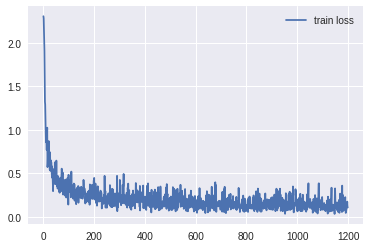

In [42]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()

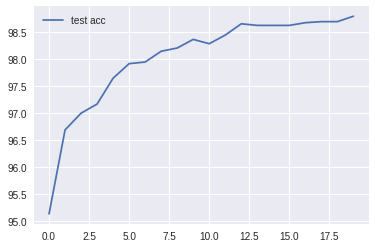

In [43]:
plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()

## ASGD

平均確率的勾配降下


```
class torch.optim.ASGD(params, lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
```



In [44]:
model = Net()
model.cuda()

#ASGD
optimizer = optim.ASGD(model.parameters())

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303558
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.314104
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.298001
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.315881
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.308984
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.302920
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.294193
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.289189
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.296589
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.301842
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.300440
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.297800
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.300560
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.282778
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.293615
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.290504
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.281220
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.299280
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.301639
Train Epoch: 1 [19000/60000 (32%)]	Loss: 2.299819
Train Epoch: 1 [200

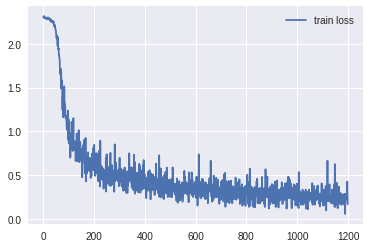

In [45]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()

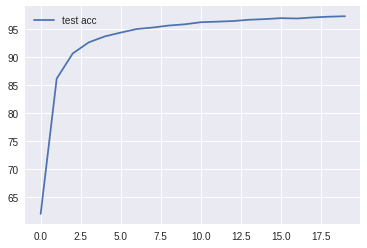

In [46]:
plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()

## LBFGS

L-BFGSアルゴリズム。


```
class torch.optim.LBFGS(params, lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
```


In [54]:
model = Net()
model.cuda()

#LBFGS
optimizer = optim.LBFGS(model.parameters())

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

TypeError: ignored

In [0]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()

In [0]:
plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()

## RMSprop

RMSpropアルゴリズム。



```
class torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
```



In [51]:
model = Net()
model.cuda()

#RMSprop
optimizer = optim.RMSprop(model.parameters())

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305191
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.313812
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.202550
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.165041
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.017931
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.942473
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.846761
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.604272
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.521252
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.369725
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.153661
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.349023
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.301761
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.137381
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.005318
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.974327
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.151575
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.975282
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.895970
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.994256
Train Epoch: 1 [200

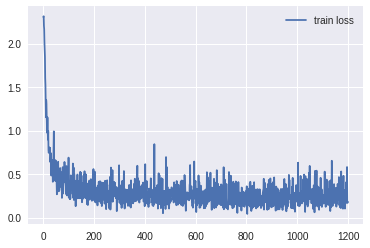

In [52]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()

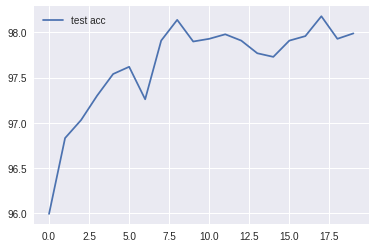

In [53]:
plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()

## Rprop

resilient backpropagationアルゴリズム。


```
class torch.optim.Rprop(params, lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
```



In [55]:
model = Net()
model.cuda()

#Rprop
optimizer = optim.Rprop(model.parameters())

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291286
Train Epoch: 1 [1000/60000 (2%)]	Loss: 1.598460
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.327001
Train Epoch: 1 [3000/60000 (5%)]	Loss: 0.958546
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.105252
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.811238
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.766176
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.856548
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.062805
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.812204
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.094272
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.944746
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.904679
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.011808
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.033272
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.188017
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.106049
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.813772
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.060678
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.932020
Train Epoch: 1 [200

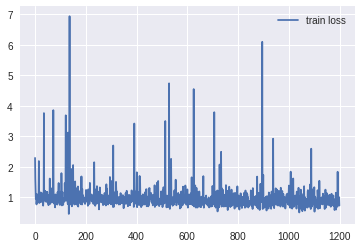

In [56]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()

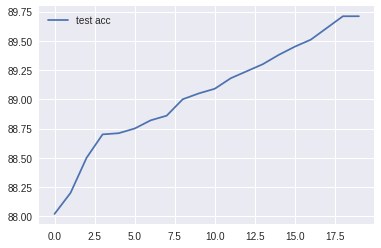

In [57]:
plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()

# 学習率を調整する


torch.optim.lr_schedulerは、エポックの数に基づいて学習率を調整するいくつかの方法を提供します。

torch.optim.lr_scheduler.ReduceLROnPlateauを使用すると、いくつかの検証測定値に基づいて動的な学習率を減らすことができます。



In [0]:
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

## LambdaLR

各パラメータグループの学習率を、与えられた関数の最初のlr倍に設定します。 last_epoch = -1のとき、lrをlrに設定します。


```
class torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)
```


In [103]:
model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

lambda1 = lambda epoch: 1.0 - max(0, epoch + 1 + epochs)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])
runner.scheduler = scheduler

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch, use_scheduler=True)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298285	 Lr：-0.2 
Train Epoch: 1 [1000/60000 (2%)]	Loss: 92.448204	 Lr：-0.2 
Train Epoch: 1 [2000/60000 (3%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [3000/60000 (5%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [4000/60000 (7%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [5000/60000 (8%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [6000/60000 (10%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [7000/60000 (12%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [8000/60000 (13%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [9000/60000 (15%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [10000/60000 (17%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [11000/60000 (18%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [12000/60000 (20%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [13000/60000 (22%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [14000/60000 (23%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [15000/60000 (25%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [16000/60000 (27%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [17000/60000 (28%)]	Loss: nan	 Lr：-0.2 
Train Epoch: 1 [18

KeyboardInterrupt: ignored

## StepLR

step_sizeエポックごとにガンマを掛けた学習率を設定する。
last_epoch = -1のとき、lrをlrに設定します。

In [104]:
model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

#2エポックごとに0.1を掛ける。
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
runner.scheduler = scheduler

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch, use_scheduler=True)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315823	 Lr：0.1 
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.297752	 Lr：0.1 
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.276303	 Lr：0.1 
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.196395	 Lr：0.1 
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.103539	 Lr：0.1 
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.968650	 Lr：0.1 
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.667592	 Lr：0.1 
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.382707	 Lr：0.1 
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.053135	 Lr：0.1 
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.122243	 Lr：0.1 
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.117997	 Lr：0.1 
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.850745	 Lr：0.1 
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.992232	 Lr：0.1 
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.966149	 Lr：0.1 
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.582080	 Lr：0.1 
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.805199	 Lr：0.1 
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.689406	 Lr：0.1 
Train Epoch: 1 [

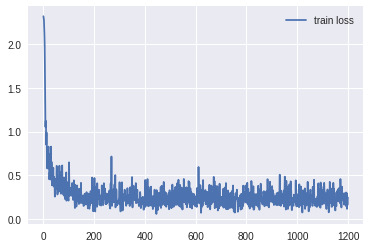

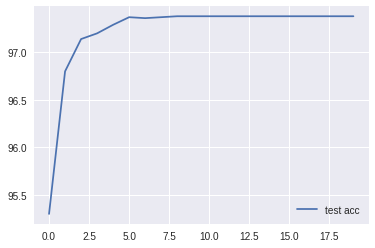

In [108]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()
plt.show()

plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()
plt.show()

## MultiStepLR

エポックのマイルストーンで学習率のガンマを掛けた学習率を設定する。

last_epoch = -1のとき、lrをlrに設定します。


```
class torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)
```



In [109]:
model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

#5エポックとに10エポックでガンマを掛ける。
scheduler = MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)
runner.scheduler = scheduler

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch, use_scheduler=True)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316896	 Lr：0.1 
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.299851	 Lr：0.1 
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.288876	 Lr：0.1 
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.272146	 Lr：0.1 
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.247838	 Lr：0.1 
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.205886	 Lr：0.1 
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.069068	 Lr：0.1 
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.810268	 Lr：0.1 
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.615397	 Lr：0.1 
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.235745	 Lr：0.1 
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.066039	 Lr：0.1 
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.039111	 Lr：0.1 
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.899079	 Lr：0.1 
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.132747	 Lr：0.1 
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.704363	 Lr：0.1 
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.702397	 Lr：0.1 
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.856190	 Lr：0.1 
Train Epoch: 1 [

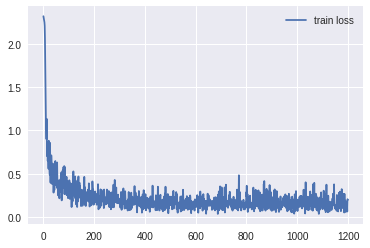

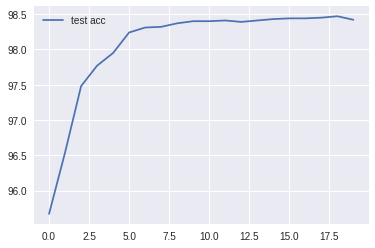

In [110]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()
plt.show()

plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()
plt.show()

## ExponentialLR


各エフェクトグループの学習率を、エポック毎にガンマで減衰した初期のlrに設定します。 last_epoch = -1のとき、lrをlrに設定します。


```
class torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
```


In [111]:
model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

#hoge
scheduler = ExponentialLR(optimizer, gamma=0.1)
runner.scheduler = scheduler

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch, use_scheduler=True)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290265	 Lr：0.1 
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.305080	 Lr：0.1 
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.316512	 Lr：0.1 
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.293149	 Lr：0.1 
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.283473	 Lr：0.1 
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.290918	 Lr：0.1 
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.249360	 Lr：0.1 
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.201528	 Lr：0.1 
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.158011	 Lr：0.1 
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.918503	 Lr：0.1 
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.674399	 Lr：0.1 
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.419221	 Lr：0.1 
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.185817	 Lr：0.1 
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.159889	 Lr：0.1 
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.991626	 Lr：0.1 
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.822580	 Lr：0.1 
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.741464	 Lr：0.1 
Train Epoch: 1 [

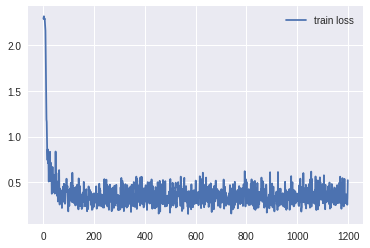

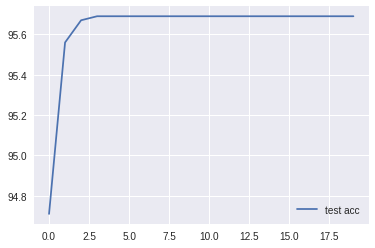

In [112]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()
plt.show()

plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()
plt.show()

## CosineAnnealingLR

```
class torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1)
```

In [113]:
model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

#hoge
scheduler = CosineAnnealingLR(optimizer, T_max=10)
runner.scheduler = scheduler

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch, use_scheduler=True)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304939	 Lr：0.1 
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.305962	 Lr：0.1 
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.282142	 Lr：0.1 
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.291943	 Lr：0.1 
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.283432	 Lr：0.1 
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.279980	 Lr：0.1 
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.229106	 Lr：0.1 
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.151435	 Lr：0.1 
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.005785	 Lr：0.1 
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.784872	 Lr：0.1 
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.497141	 Lr：0.1 
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.336607	 Lr：0.1 
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.214791	 Lr：0.1 
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.997139	 Lr：0.1 
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.778537	 Lr：0.1 
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.933711	 Lr：0.1 
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.744743	 Lr：0.1 
Train Epoch: 1 [

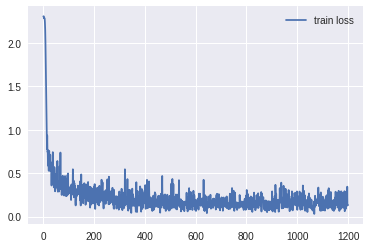

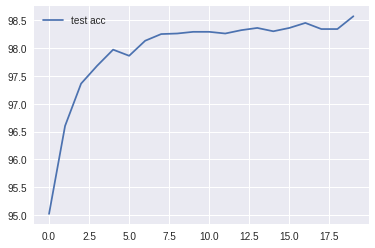

In [114]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()
plt.show()

plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()
plt.show()

## ReduceLROnPlateau

メトリックが改善しなくなったときの学習率を減らす。モデルは、学習が停滞すると、学習率を2〜10倍に低下させることにより、しばしば利益を得る。このスケジューラはメトリック量を読み取り、「patience：忍耐」数のエポックに改善が見られない場合は、学習率が低下します。




In [0]:
model = Net()
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list = []
test_loss_list = []
correct_list = []

runner = Runner(model)

#hoge
scheduler = ReduceLROnPlateau(optimizer, 'min')
runner.scheduler = scheduler

def main(optimizer, model):
    for epoch in range(1, epochs + 1):
        ref_loss = runner.train(model, device, train_loader, optimizer, epoch, use_scheduler=True)
        train_loss_list.extend(ref_loss)
        ref_loss, ref_correct = runner.test(model, device, test_loader)
        test_loss_list.extend(ref_loss)
        correct_list.extend(ref_correct)
    return train_loss_list, test_loss_list, correct_list
        
train_loss_list, test_loss_list, correct_list = main(optimizer, model)

In [0]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.legend()
plt.show()

plt.plot(np.arange(len(correct_list)), correct_list, label="test acc")
plt.legend()
plt.show()